Student Name: Aidan Keeshan<br>
Student ID:   18200117<br>
Model Type:   Classification<br>

# Data Set Selection
Initially I decided to look at K Nearest Neighbour (KNN) as classification model. Majority of examples on the internet used the Iris [dataset](https://archive.ics.uci.edu/ml/datasets/iris) which is classifies flowers based on dimesons of physical appearance.

This however only had 150 records which would not satisfy the minimum of 500 records. Reviewing the UCI website, I decided to use the letters [dataset](https://archive.ics.uci.edu/ml/datasets/letter+recognition).

Running KNN on a setting cluster to 26 found poor correlation with labelled data.

Concluded that KNN is not the best or most mature classifier to use for supervised learning.



After further review of Kaggle I decided to use Risk Factors Cervical Cancer [dataset](https://www.kaggle.com/loveall/cervical-cancer-risk-classification).

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

rfcc = pd.read_csv('data/kag_risk_factors_cervical_cancer.csv', na_values = ['?'])
print ("Dataset Shape: Rows {} x Cols {}".format(rfcc.shape[0],rfcc.shape[1]))

Dataset Shape: Rows 858 x Cols 36


# Data Set Summary
The graph below was inspired by an R plot which gives good overview of the population of the data. <br> When the data was first loaded there was no null observation. Based on this reviewed I reviewed <br> the head of the data frame and saw there ‘?’ where there should be nulls. <br> I have incorporated this into the pandas csv load to set as null. <br>
As I would like to operate over the fields I have returned the Null summary of the original dataset.

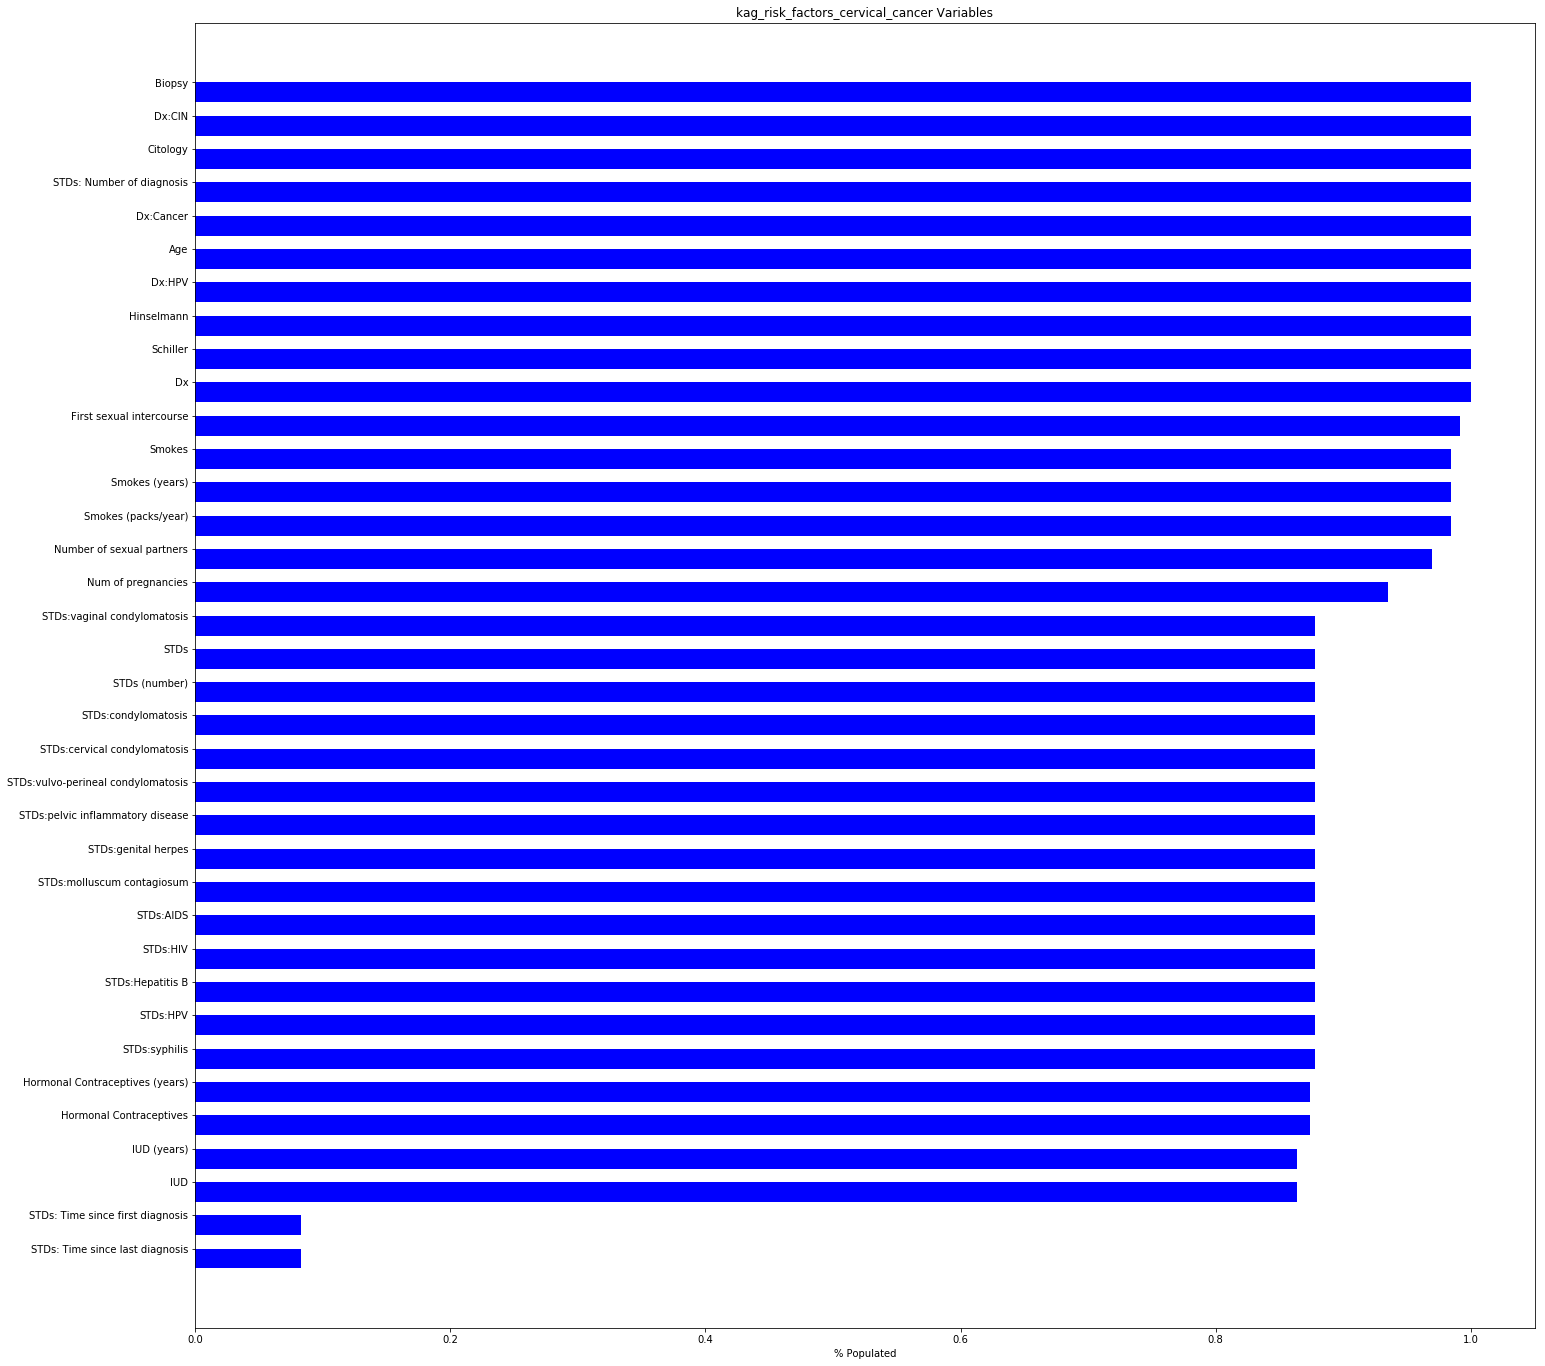

In [92]:
def summary_df(df,title='Data Varaible'):
    summary = (len(df) - df.isnull().sum())/len(df)
    summary = pd.DataFrame({'VARNAME' : summary.index.values, 'VARNULLPER': summary.reset_index(drop=True)}).sort_values(by=['VARNULLPER'])
    fig, ax = plt.subplots(figsize=(24, 24)) 
    width = 0.6 # the width of the bars 
    ind = np.arange(len(summary))  # the x locations for the groups
    ax.barh(ind, summary['VARNULLPER'], width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(summary['VARNAME'], minor=False)
    plt.title(title)
    plt.xlabel('% Populated')
    plt.show()
    return summary

rfcc_summary = summary_df(rfcc,'kag_risk_factors_cervical_cancer Variables')

## Correlation Matrix 
To further investigate the dataset I preformed a correlation matrix of the values which are all numeric.<br> 
The correlation matrix was too large to read easily. As the correlation matrix calculation is faster than the plotting, I decided to split the matrix into 2 with high and low maximum absolute value correlation.<br>
I have stripped out where correlation of 1 as is either the field with itself or a proxy value containing same information. As the resulting correlation are order by abs correlation shows some interesting outputs.<br>
The highly correlated values are clustered from top left to bottom right.<br>
Unfortunately the target variable DX is just by the cut off point (17 highest correlation).<br>
It also shows relatively high correlation with of DX with Hinselmann.<br>

In [100]:
corr_mat = rfcc.corr()
corr_mat = corr_mat.replace(1, 0)
max_corr = corr_mat.abs().max().replace(np.nan, 0).sort_values(ascending=False)
high_low = np.split(max_corr.index.values, 2)
high_low

[array(['STDs:vulvo-perineal condylomatosis', 'STDs:condylomatosis',
        'STDs: Time since last diagnosis',
        'STDs: Time since first diagnosis', 'STDs (number)', 'STDs',
        'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:HPV', 'IUD',
        'IUD (years)', 'Schiller', 'Biopsy', 'Smokes (years)',
        'Smokes (packs/year)', 'Smokes', 'Dx', 'Hinselmann'], dtype=object),
 array(['Dx:CIN', 'Num of pregnancies', 'Age', 'STDs:HIV', 'STDs:syphilis',
        'Hormonal Contraceptives (years)', 'Hormonal Contraceptives',
        'First sexual intercourse', 'Citology',
        'STDs:vaginal condylomatosis', 'STDs:HPV', 'STDs:Hepatitis B',
        'Number of sexual partners', 'STDs:genital herpes',
        'STDs:pelvic inflammatory disease', 'STDs:molluscum contagiosum',
        'STDs:cervical condylomatosis', 'STDs:AIDS'], dtype=object)]

## Plot Highly Correlated 18 Variables

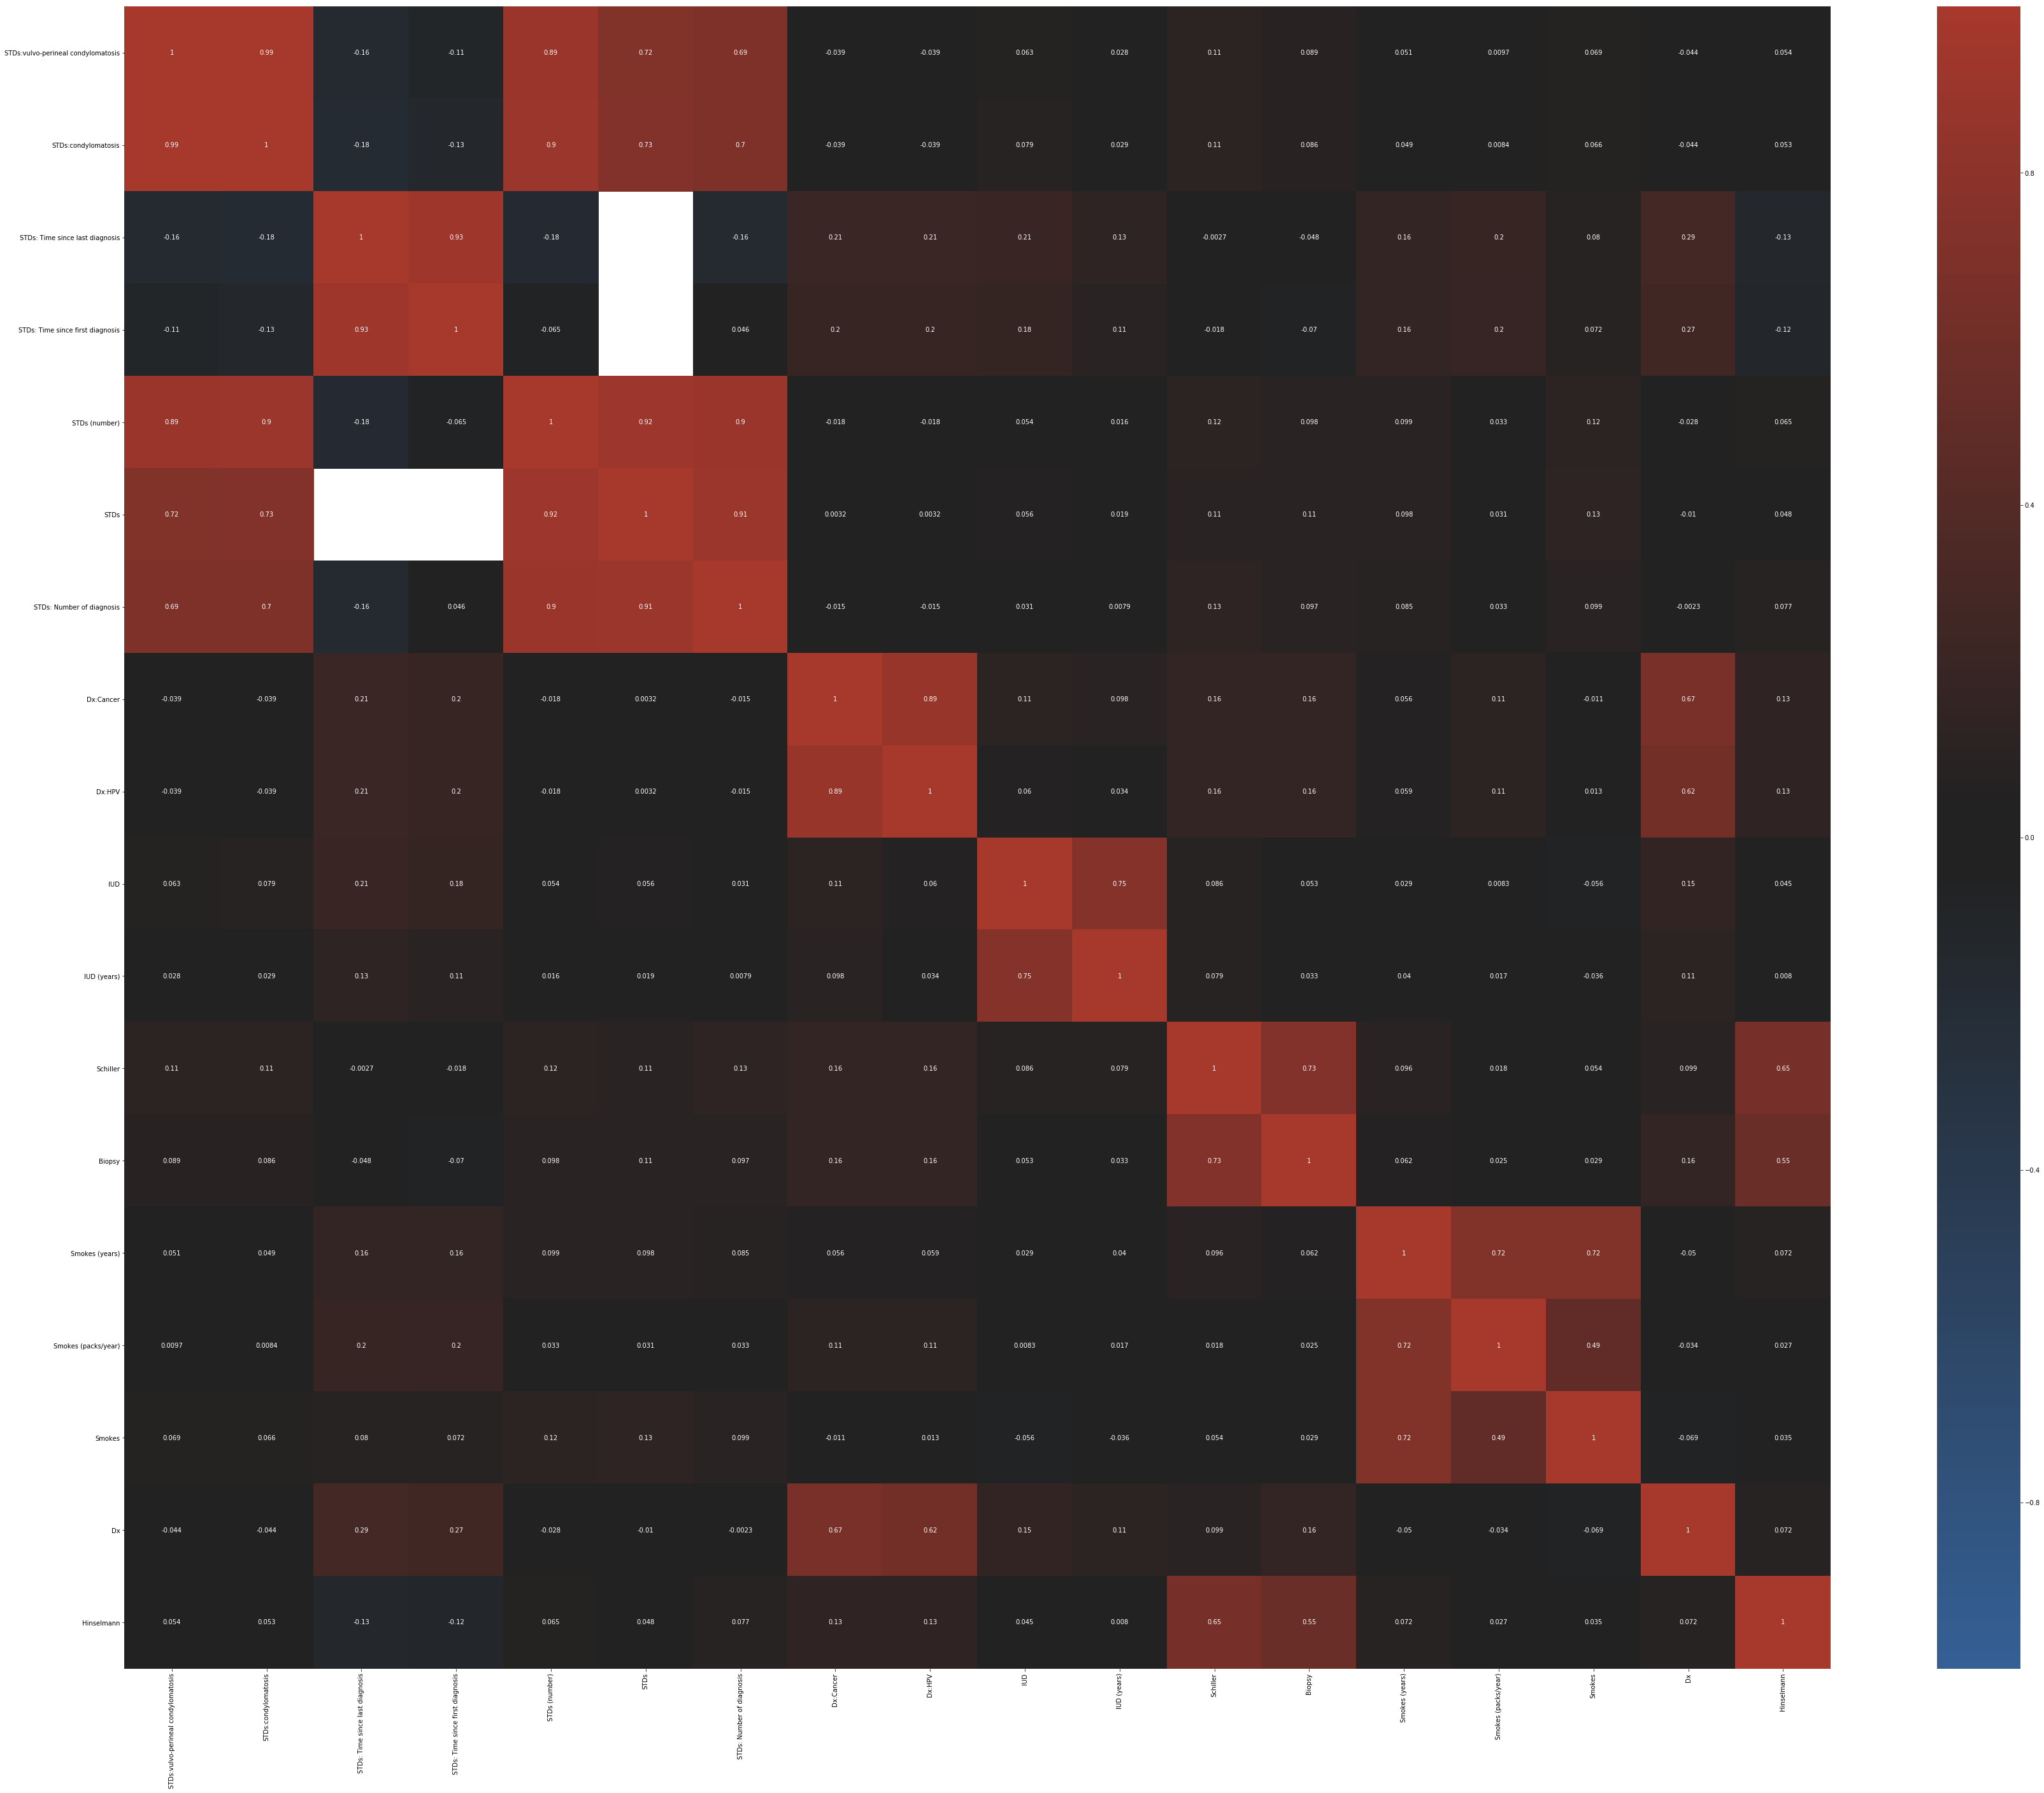

In [103]:
import seaborn as sn
fig, ax = plt.subplots(figsize=(60, 48))
div_pal = sn.diverging_palette(250, 15, s=75, l=40, center="dark", as_cmap=True)
plot = sn.heatmap(rfcc[high_low[0]].corr(),vmin=-1,vmax=1,center=0, annot=True, cmap=div_pal, ax=ax)

## Plot Lower Correlated 18 Variables

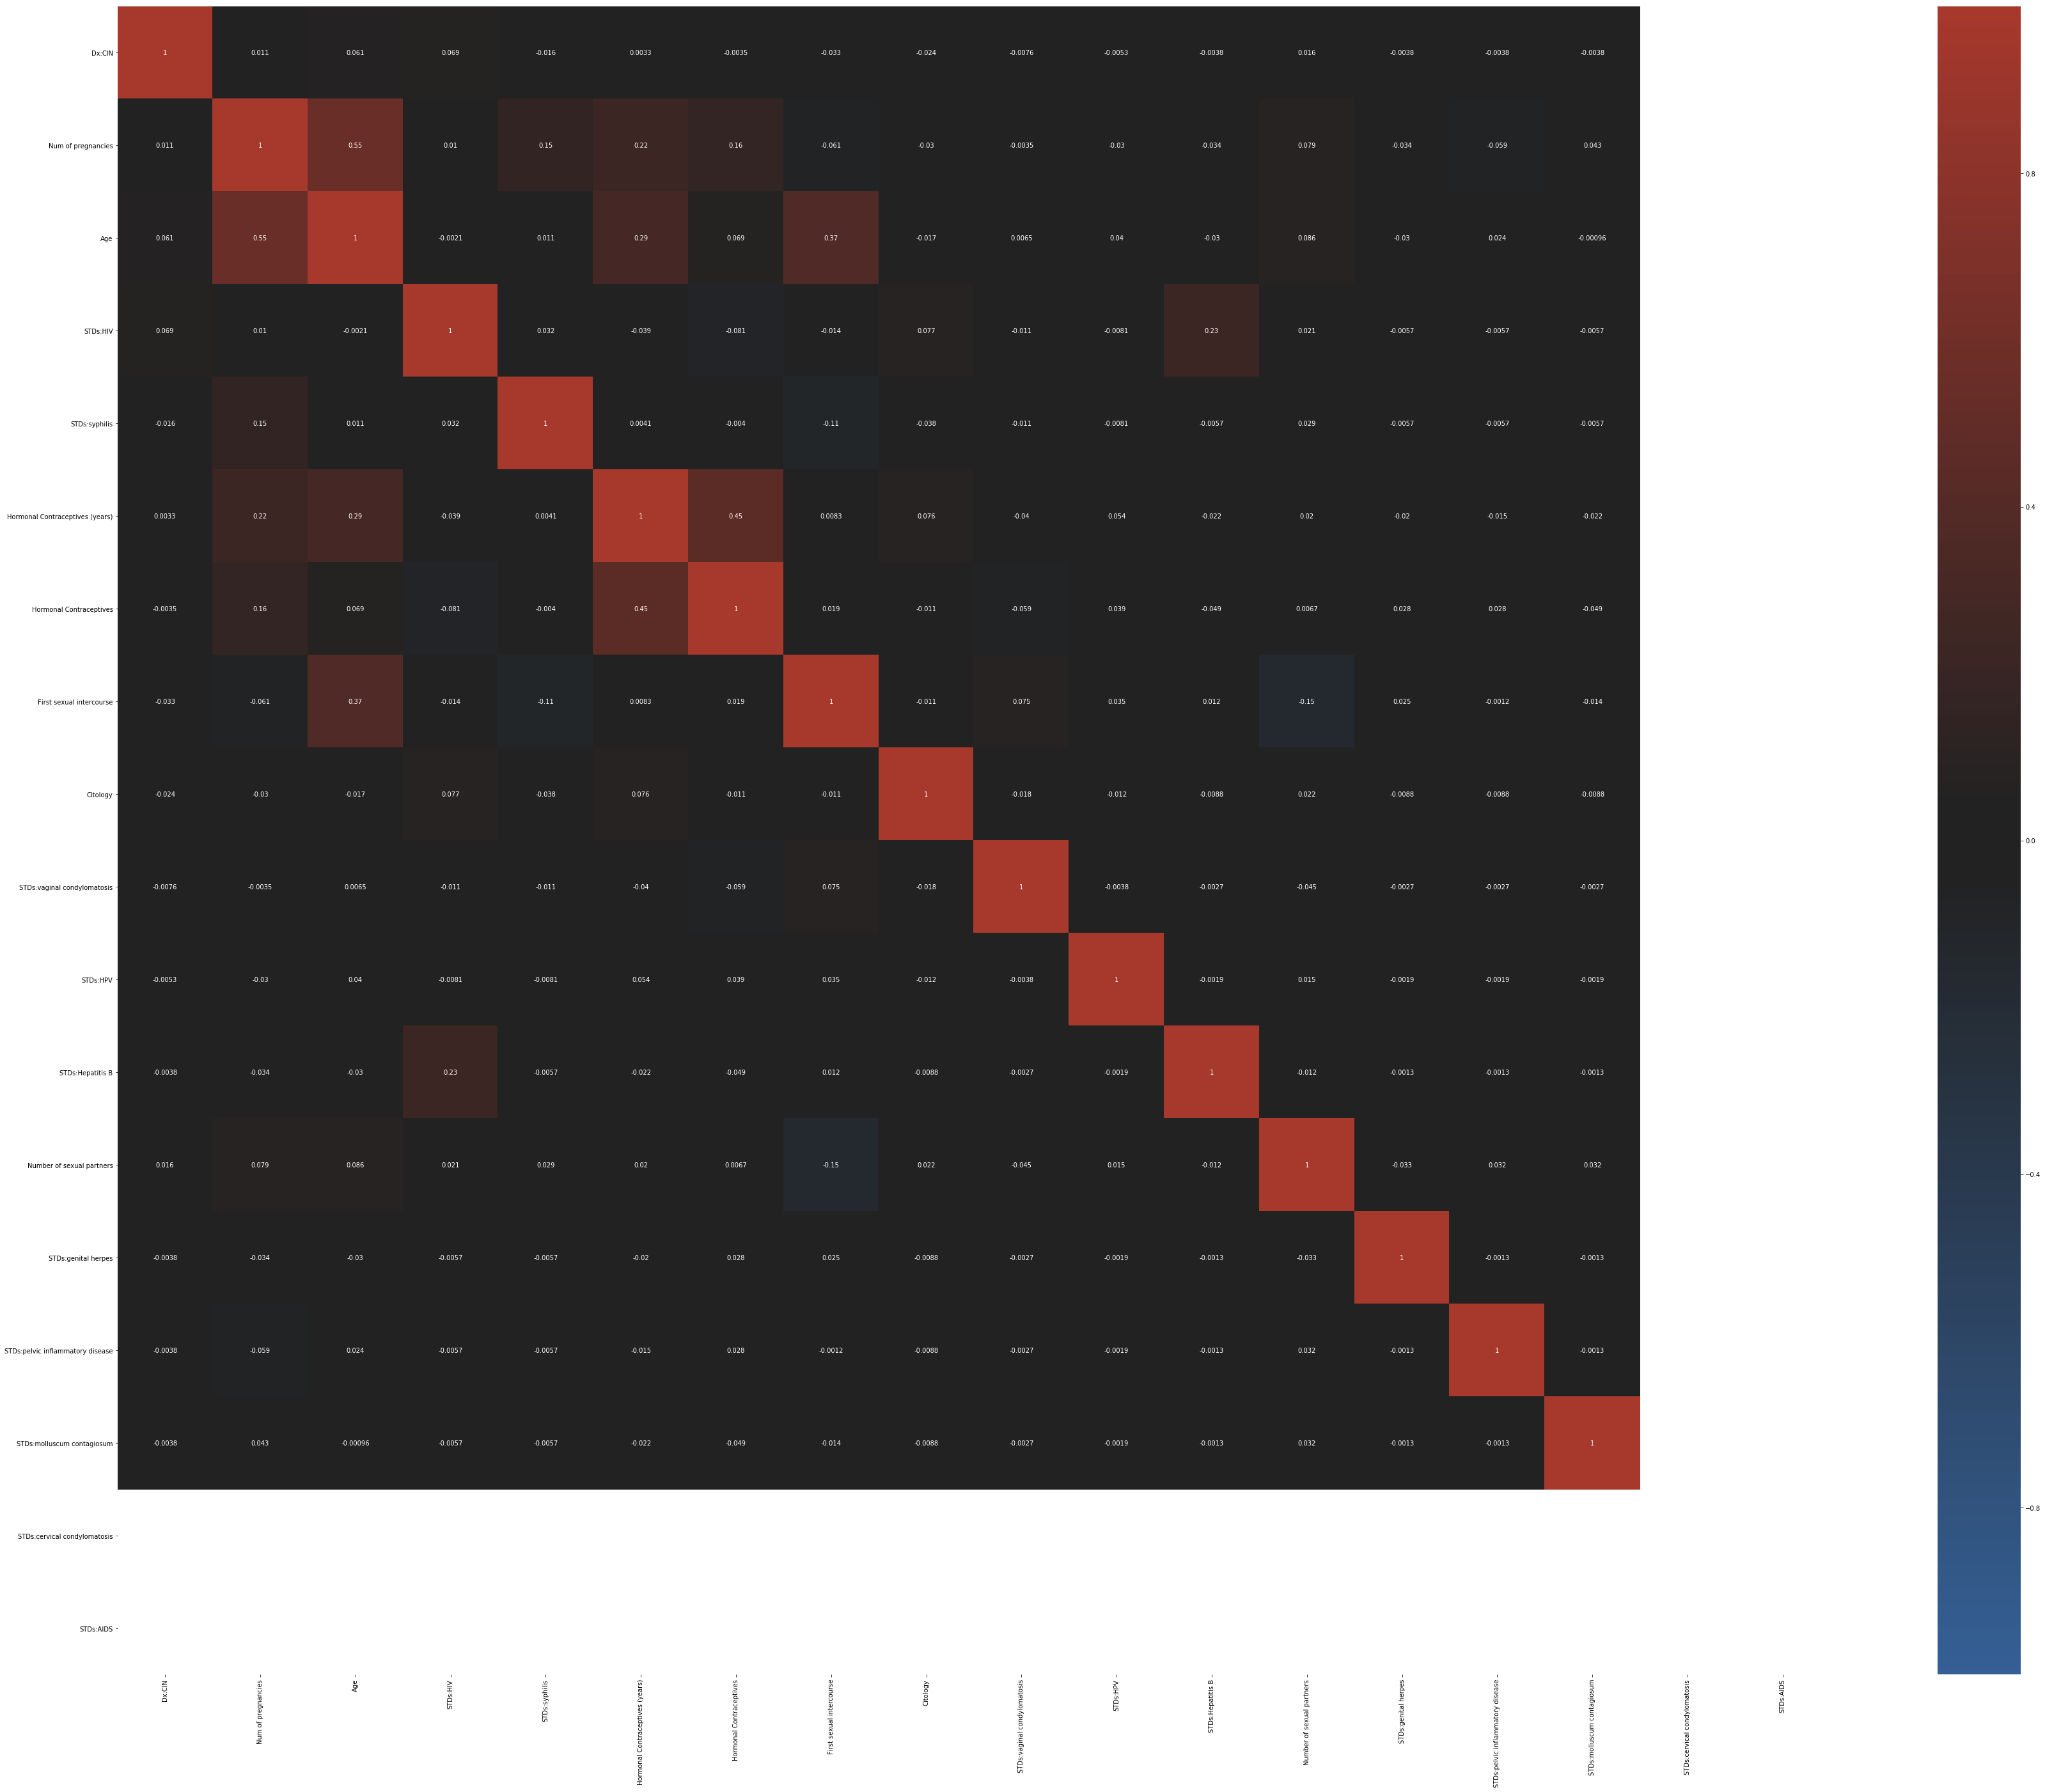

In [104]:
fig, ax = plt.subplots(figsize=(60, 48))
plot = sn.heatmap(rfcc[high_low[1]].corr(),vmin=-1,vmax=1,center=0, annot=True, cmap=div_pal, ax=ax)

In [6]:
rfcc_null_zero = rfcc.replace(np.nan, 0).copy()
def apply_null(df,cutoff=0):
    df_return = df.copy()
    for i, row  in rfcc_summary.iterrows():
        if row['VARNULLPER'] <= cutoff:
            df_return = df_return.drop(row['VARNAME'],1)
        elif row['VARNULLPER'] != 1:
            df_return[row['VARNAME']].fillna((df_return[row['VARNAME']].mean()), inplace=True)
    return df_return

rfcc_null_mean = apply_null(rfcc)
rfcc_null_mean_co = apply_null(rfcc,0.2)
print (rfcc_null_mean.shape)
print (rfcc_null_mean_co.shape)

(858, 36)
(858, 34)


In [40]:
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def split_data(df,target):
    y = np.array(df[target])
    X = df.drop(target, 1)
    X = X.replace(np.nan, 0)
    return train_test_split(X, y, test_size=0.33, random_state=42)

def plot_confusion_matrix(y_test, y_pred,title = 'Title'):
    conf_mat = confusion_matrix(y_test, y_pred)
    log_norm = LogNorm(vmin=conf_mat.min().min(), vmax=conf_mat.max().max())
    #plt.figure()
    #ax = plt.axes()
    sn.heatmap(conf_mat,cmap="Blues",annot=True,fmt='g',norm=log_norm)
    #ax.set_title(title)
    #plt.figure()



In [78]:
X_train, X_test, y_train, y_test,model = None,None,None,None,None
X_train, X_test, y_train, y_test = split_data(rfcc_null_mean_co,'Dx:Cancer')
model = RandomForestClassifier(n_estimators = 200)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print (score)
#plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))
estimator = model.estimators_[42]
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = 'Target',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


# Display in jupyter notebook


0.9964788732394366


![](https://gitlab.com/CE4021/Group2/project/raw/group_2_1/tree.png?inline=false)

In [75]:
X_train.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:CIN',
       'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'],
      dtype='object')

In [50]:
X_train, X_test, y_train, y_test = split_data(rfcc_null_mean,'Dx:Cancer')
model = RandomForestClassifier(n_estimators = 200)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print (score)

0.9929577464788732


0.9929577464788732


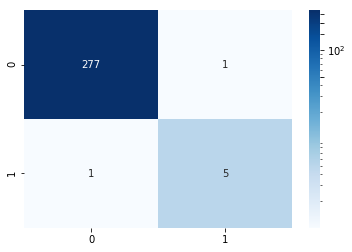

In [51]:
X_train, X_test, y_train, y_test,model = None,None,None,None,None
X_train, X_test, y_train, y_test = split_data(rfcc_null_mean_co,'Dx:Cancer')
model = RandomForestClassifier(n_estimators = 200)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print (score)
plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))

In [55]:
param_grid = [
        {'bootstrap': [False, True],
         'n_estimators': [80,90, 100, 110, 130,200],
         'max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
         'min_samples_leaf': [10, 12, 14],
         'min_samples_split': [3, 5, 7]
        },
    ]

X_train, X_test, y_train, y_test = split_data(rfcc_null_zero,'Dx:Cancer')
random_forest_classifier = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5,scoring='neg_mean_squared_error', refit=True,n_jobs=8)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
#plot_confusion_matrix(y_test, y_pred,'Model Accuracy: {:.1%}'.format(score))
print (score)

0.9929577464788732


In [69]:
X_train, X_test, y_train, y_test = split_data(rfcc_null_zero,'Dx:Cancer')
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

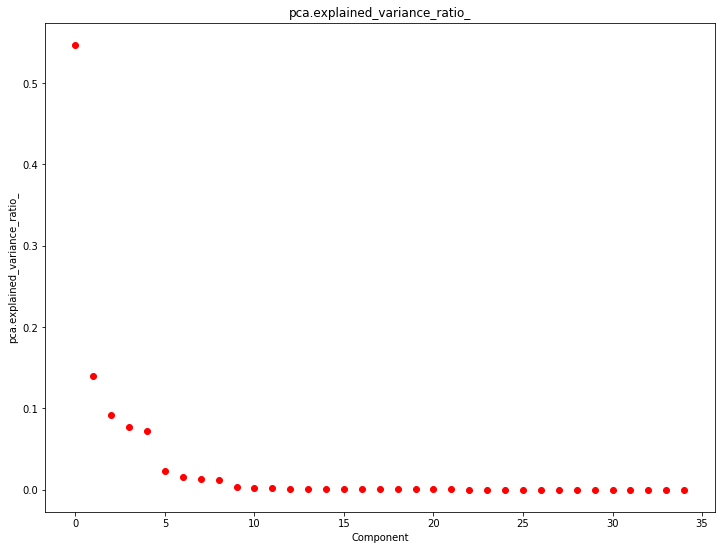

The explained variance ratio shows how much each component contributes to overall variance.
The total overall variance is 1.0
The first component of the PCA analysis contributes over 25% of the total variance
After about 20 components, the amount of variance contributed by each component starts getting to 1% or less


In [70]:
# Adjust Size of Figures
plt.rcParams["figure.figsize"] = (12,9)


plt.title('pca.explained_variance_ratio_')
plt.ylabel('pca.explained_variance_ratio_')
plt.xlabel('Component')
plt.plot(pca.explained_variance_ratio_, 'or')
plt.show()

print("The explained variance ratio shows how much each component contributes to overall variance.")
print("The total overall variance is 1.0")
print("The first component of the PCA analysis contributes over 25% of the total variance")
print("After about 20 components, the amount of variance contributed by each component starts getting to 1% or less")